In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

NVDA = pd.read_csv("nvidia_stock_2015_to_2024.csv")

In [2]:
# Data processing
NVDA = NVDA.drop("Unnamed: 0", axis = 1)
NVDA["date"] = pd.to_datetime(NVDA["date"])

NVDA = NVDA.sort_values("date").reset_index(drop=True)

NVDA.head()

# Create target variable: 1 if price goes up the next day, else 0
NVDA["target"] = (NVDA["close"].shift(-1) > NVDA["close"]).astype(int)

# Drop the last row since we can't predict its next-day movement
NVDA = NVDA[:-1]


In [3]:
NVDA

,date,open,high,low,close,adjclose,volume,target
0,2015-01-02,0.503250,0.507000,0.495250,0.503250,0.483218,113680000,0
1,2015-01-05,0.503250,0.504750,0.492500,0.494750,0.475056,197952000,0
2,2015-01-06,0.495500,0.496000,0.479250,0.479750,0.460654,197764000,0
3,2015-01-07,0.483250,0.487500,0.477000,0.478500,0.459453,321808000,1
4,2015-01-08,0.484000,0.499500,0.483750,0.496500,0.476737,283780000,1
...,...,...,...,...,...,...,...,...
2363,2024-05-23,102.028000,106.320000,101.519997,103.799004,103.790482,835065000,1
2364,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.460258,429494000,1
2365,2024-05-28,110.244003,114.939003,109.883003,113.901001,113.891647,652728000,1
2366,2024-05-29,113.050003,115.491997,110.901001,114.824997,114.815567,557442000,0


In [4]:
# How many increasing trend in total
NVDA["target"].sum()/len(NVDA["target"])

0.5464527027027027

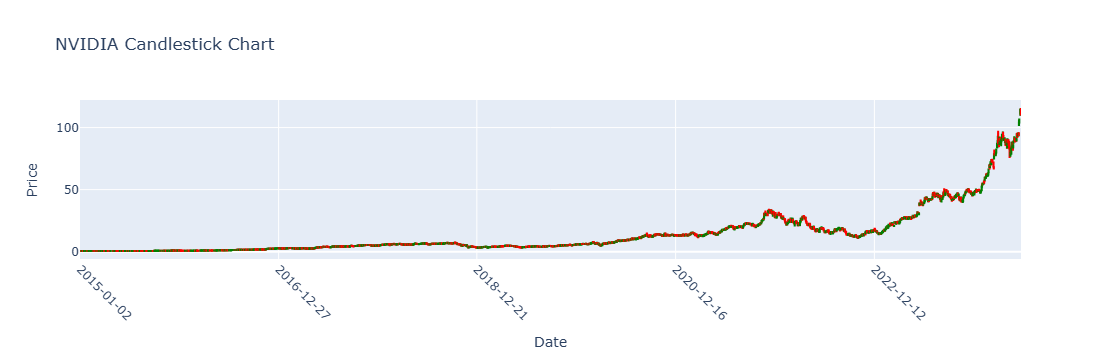

In [58]:
#Plot candle plot

fig = go.Figure(data=[go.Candlestick(
    x=NVDA['date'],
    open=NVDA['open'],
    high=NVDA['high'],
    low=NVDA['low'],
    close=NVDA['close'],
    increasing_line_color='green', decreasing_line_color='red'
)])

fig.update_layout(
    title='NVIDIA Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    xaxis=dict(
        tickmode='array',  
        tickvals=NVDA['date'][::500],  
        ticktext=[str(date.date()) for date in NVDA['date'][::500]],  
        tickformat="%Y-%m-%d",  
        tickangle=45,  
        showgrid=True  
    )
)
fig.show()

In [6]:
# Define features (using only Close price) and target
X = NVDA[["close","volume", "high","low","open"]]
y = NVDA["target"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# a basic KNN model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, conf_matrix


(0.44936708860759494,
 array([[156,  52],
        [209,  57]], dtype=int64))

In [8]:
df_cleaned = NVDA.copy()

In [9]:
# Feature Engineering

import pandas_ta as ta

df_cleaned['Lag1'] = (df_cleaned['close'].shift(1) - df_cleaned['close'].shift(2)) / df_cleaned['close'].shift(2)
df_cleaned['Lag2'] = (df_cleaned['close'].shift(1) - df_cleaned['close'].shift(3)) / df_cleaned['close'].shift(3)
df_cleaned['Lag3'] = (df_cleaned['close'].shift(1) - df_cleaned['close'].shift(4)) / df_cleaned['close'].shift()
df_cleaned['Lag4'] = (df_cleaned['close'].shift(1) - df_cleaned['close'].shift(5)) / df_cleaned['close'].shift(5)
df_cleaned['Lag5'] = (df_cleaned['close'].shift(1) - df_cleaned['close'].shift(6)) / df_cleaned['close'].shift(6)
df_cleaned["RSI"] = ta.rsi(df_cleaned["close"], length=14)  # 14-day RSI
df_cleaned["OBV"] = ta.obv(df_cleaned["close"], df_cleaned["volume"]) # OBV
df_cleaned["SMA5"] = ta.sma(df_cleaned["close"], length=5) #SMA
df_cleaned["SMA10"] = ta.sma(df_cleaned["close"], length=10) #SMA
df_cleaned["SMA15"] = ta.sma(df_cleaned["close"], length=15) #SMA
df_cleaned["SMA2"] = ta.sma(df_cleaned["close"], length=2) #SMA
df_cleaned["SMA3"] = ta.sma(df_cleaned["close"], length=3) #SMA
df_cleaned[["MACD", "MACD_Signal", "MACD_Histogram"]] = ta.macd(df_cleaned["close"])
df_cleaned["CCI"] = ta.cci(high=df_cleaned["high"], low=df_cleaned["low"], close=df_cleaned["close"])

# Drop NaN values 
df_features = df_cleaned.dropna()

df_features

,date,open,high,low,close,adjclose,volume,target,Lag1,Lag2,...,OBV,SMA5,SMA10,SMA15,SMA2,SMA3,MACD,MACD_Signal,MACD_Histogram,CCI
33,2015-02-20,0.554000,0.558750,0.550000,0.558500,0.536269,157752000,0,0.002712,-0.008937,...,8.808080e+08,0.556650,0.540425,0.526250,0.556500,0.555333,0.016419,0.005992,0.010427,77.505586
34,2015-02-23,0.558250,0.558250,0.551250,0.554000,0.531948,125008000,1,0.007214,0.009946,...,7.558000e+08,0.555900,0.544825,0.531183,0.556250,0.555667,0.016450,0.004818,0.011632,63.269437
35,2015-02-24,0.554000,0.557750,0.549000,0.557750,0.537611,149356000,0,-0.008057,-0.000902,...,9.051560e+08,0.555550,0.549650,0.535667,0.555875,0.556750,0.016585,0.003963,0.012622,56.076994
36,2015-02-25,0.555500,0.558000,0.551000,0.553500,0.533515,123820000,1,0.006769,-0.001343,...,7.813360e+08,0.555650,0.552625,0.539050,0.555625,0.555083,0.016163,0.002833,0.013330,47.560666
37,2015-02-26,0.554000,0.558250,0.550500,0.555000,0.534960,152864000,0,-0.007620,-0.000903,...,9.342000e+08,0.555750,0.556100,0.542450,0.554250,0.555417,0.015768,0.001950,0.013818,43.712532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,2024-05-23,102.028000,106.320000,101.519997,103.799004,103.790482,835065000,1,-0.004571,0.001794,...,1.052364e+11,96.278799,94.201600,92.843867,99.374500,98.045001,3.121242,1.027565,2.093677,274.666298
2364,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.460258,429494000,1,0.093196,0.088200,...,1.056659e+11,99.076801,95.860700,94.022534,105.134003,101.739334,3.868120,1.419554,2.448566,220.257905
2365,2024-05-28,110.244003,114.939003,109.883003,113.901001,113.891647,652728000,1,0.025723,0.121317,...,1.063186e+11,102.901001,98.210900,95.473267,110.185001,108.056335,5.002065,2.042800,2.959266,228.581518
2366,2024-05-29,113.050003,115.491997,110.901001,114.824997,114.815567,557442000,0,0.069804,0.097323,...,1.068760e+11,106.788800,100.557800,97.091334,114.362999,111.731667,5.907190,2.358339,3.548851,164.225162


In [10]:
features = ["SMA5", "SMA15", "Lag1","Lag2", "Lag3", "Lag4", "Lag5", "OBV",  "RSI", "MACD", "CCI"]
X_features = df_features[features]
y_features = df_features["target"]

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features, y_features, test_size=0.2, random_state=42, shuffle=False)

# Standardize features
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)

In [11]:
# percentage of the decreasing trend among the test set
y_test_f.sum()/len(y_test_f)

0.556745182012848

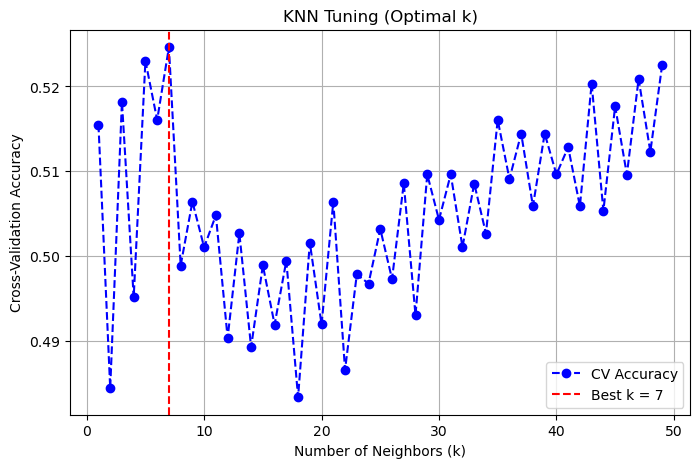

(7, 0.5246175682069074)

In [12]:
# tune k with mean value of cross validation

# Define range of k values to test
k_values = range(1, 50)

cv_scores = []

# Perform cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_f_scaled, y_train_f, cv=5, scoring="accuracy") 
    cv_scores.append(scores.mean())  # Store mean accuracy

best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o', linestyle='dashed', color='b', label="CV Accuracy")
plt.axvline(best_k, color='r', linestyle='--', label=f"Best k = {best_k}")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Tuning (Optimal k)")
plt.legend()
plt.grid(True)
plt.show()

best_k, best_score

In [13]:
knn = KNeighborsClassifier(n_neighbors=best_k)


# Train KNN again with new features
knn.fit(X_train_f_scaled, y_train_f)
y_pred_f = knn.predict(X_test_f_scaled)
y_pred_f_prob = knn.predict_proba(X_test_f_scaled)
accuracy_f = accuracy_score(y_test_f, y_pred_f)
conf_matrix_f = confusion_matrix(y_test_f, y_pred_f)

In [14]:
print(conf_matrix_f)
print(accuracy_f)
print(roc_auc_score(y_test_f, y_pred_f_prob[:,1]))

[[129  78]
 [158 102]]
0.49464668094218417
0.5080732069862505


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=42)
}

# Define an evaluating function

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    cof_m = confusion_matrix(y_test, y_pred)
    return accuracy, precision, auc_score, cof_m

# Evaluate for each model
for n, classifier in classifiers.items():
    print(f"Scores for {n}")
    accuracy, precision, auc_score, cofu = evaluate_model(classifier, X_train_f_scaled, X_test_f_scaled, y_train_f, y_test_f)
    print(f'Accuracy={accuracy}')
    print(f'AUC Score={auc_score}')
    print(f'Precision={precision}')
    print(cofu)
    print("")

Scores for Logistic Regression
Accuracy=0.4518201284796574
AUC Score=0.4871051653660349
Precision=0.5172413793103449
[[151  56]
 [200  60]]

Scores for SVM
Accuracy=0.5074946466809421
AUC Score=0.49827201783723524
Precision=0.5572519083969466
[[ 91 116]
 [114 146]]

Scores for Random Forest
Accuracy=0.4753747323340471
AUC Score=0.5153939056112968
Precision=0.5700934579439252
[[161  46]
 [199  61]]

Scores for KNN
Accuracy=0.5032119914346895
AUC Score=0.526189149015236
Precision=0.5795454545454546
[[133  74]
 [158 102]]

Scores for XGBoost
Accuracy=0.5096359743040685
AUC Score=0.5217019695280566
Precision=0.5714285714285714
[[114  93]
 [136 124]]



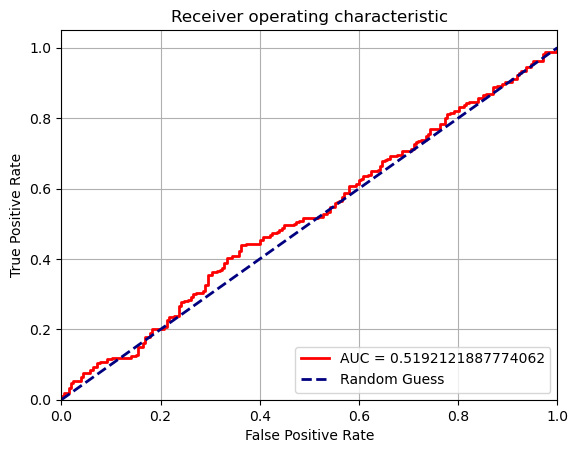

In [16]:
#Plot the ROC curve since the XGBoost perform the best
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.3, max_depth=3, random_state=42)
model.fit(X_train_f_scaled, y_train_f)
y_pred_prob = model.predict_proba(X_test_f_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test_f, y_pred_prob)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'AUC = {auc_score}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

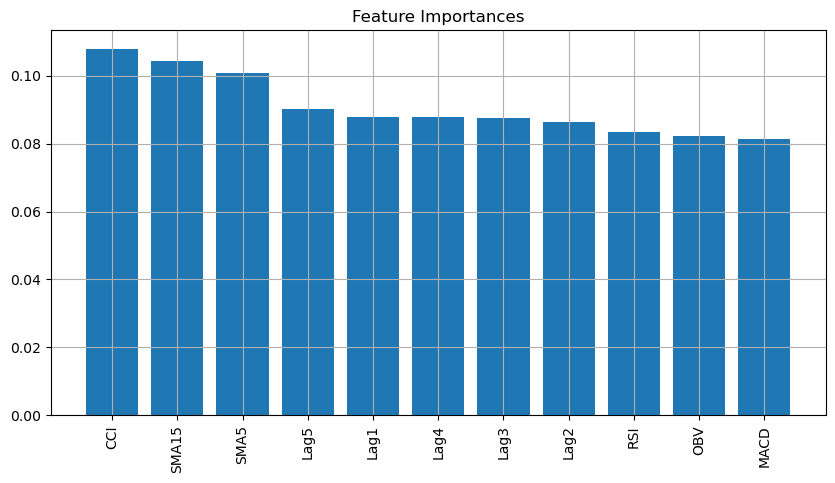

In [17]:
# Feature Importance plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train_f_scaled.shape[1]), importances[indices])
plt.xticks(range(X_train_f_scaled.shape[1]), X_train_f.columns[indices], rotation=90)
plt.grid(True)
plt.show()

In [18]:
# Tune XGBoost parameters, using cross_validation(accuracy)
from sklearn.model_selection import train_test_split, GridSearchCV
xgb_model = xgb.XGBClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': range(40, 160, 20),
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    'max_depth': range(2,10,1),
}

# Set up cross-validation strategy

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train_f_scaled, y_train_f)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_f_scaled)
print("Test Accuracy:", accuracy_score(y_test_f, y_pred))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 40}
Best Cross-Validation Accuracy: 0.5310232111367579
Test Accuracy: 0.5182012847965739


In [19]:
# the AUC for this model
y_pred = best_model.predict(X_test_f_scaled)
print(accuracy_score(y_test_f,y_pred))
print(precision_score(y_test_f, y_pred, pos_label=1))
print(roc_auc_score(y_test_f, best_model.predict_proba(X_test_f_scaled)[:,1]))

0.5182012847965739
0.5732217573221757
0.49596804162021546


In [20]:
# Hard Voting 

from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[
        ('svm', classifiers['SVM']),
        ('knn', classifiers['KNN']),
        ('XG', best_model)
    ],
    voting='hard'
)

# Print all the classifiers
classifiers['Voting Classifier'] = voting_classifier


print("Voting Classifier (hard voting) results:")
voting_classifier.fit(X_train_f_scaled, y_train_f)
y_pred = voting_classifier.predict(X_test_f_scaled)


accuracy = accuracy_score(y_test_f, y_pred)
precision = precision_score(y_test_f, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(confusion_matrix(y_test_f,y_pred))

Voting Classifier (hard voting) results:
Accuracy: 0.5160599571734475
Precision: 0.5801886792452831
[[118  89]
 [137 123]]


### The following part is not included in the essay/powerpoint, because i find this 'arbitrage' not sensible

In [22]:
# Fit TSM for arbitrage 
TSMC = pd.read_csv("TSMC_2021_2022.csv")

In [23]:
TSMC["Date"] = pd.to_datetime(TSMC["Date"])
TSMC = TSMC.sort_values("Date").reset_index(drop=True)
TSMC['Volume'] = TSMC['Volume'].str.replace(',', '').astype(float)
TSMC.tail()

,Date,Open,High,Low,Close,Volume
240,2022-04-19,566.0,569.0,563.0,565.0,17169240.0
241,2022-04-20,570.0,570.0,562.0,570.0,28124221.0
242,2022-04-21,571.0,571.0,565.0,565.0,19006080.0
243,2022-04-22,558.0,559.0,557.0,558.0,31803891.0
244,2022-04-25,550.0,552.0,546.0,547.0,48976359.0


In [24]:
TSMC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    245 non-null    datetime64[ns]
 1   Open    245 non-null    float64       
 2   High    245 non-null    float64       
 3   Low     245 non-null    float64       
 4   Close   245 non-null    float64       
 5   Volume  245 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.6 KB


In [25]:
# Feature engineering

TSMC["target"] = (TSMC["Close"].shift(-1) > TSMC["Close"]).astype(int)
df_cleaned = TSMC.copy()
df_cleaned['Lag1'] = (df_cleaned['Close'].shift(1) - df_cleaned['Close'].shift(2)) / df_cleaned['Close'].shift(2)
df_cleaned['Lag2'] = (df_cleaned['Close'].shift(1) - df_cleaned['Close'].shift(3)) / df_cleaned['Close'].shift(3)
df_cleaned['Lag3'] = (df_cleaned['Close'].shift(1) - df_cleaned['Close'].shift(4)) / df_cleaned['Close'].shift(4)
df_cleaned['Lag4'] = (df_cleaned['Close'].shift(1) - df_cleaned['Close'].shift(5)) / df_cleaned['Close'].shift(5)
df_cleaned['Lag5'] = (df_cleaned['Close'].shift(1) - df_cleaned['Close'].shift(6)) / df_cleaned['Close'].shift(6)
df_cleaned["RSI"] = ta.rsi(df_cleaned["Close"], length=14)  # 14-day RSI
df_cleaned["OBV"] = ta.obv(df_cleaned["Close"], df_cleaned["Volume"]) # OBV
df_cleaned["SMA5"] = ta.sma(df_cleaned["Close"], length=5) #SMA
df_cleaned["SMA10"] = ta.sma(df_cleaned["Close"], length=10) #SMA
df_cleaned["SMA15"] = ta.sma(df_cleaned["Close"], length=15) #SMA
df_cleaned["SMA2"] = ta.sma(df_cleaned["Close"], length=2) #SMA
df_cleaned["SMA3"] = ta.sma(df_cleaned["Close"], length=3) #SMA
df_cleaned[["MACD", "MACD_Signal", "MACD_Histogram"]] = ta.macd(df_cleaned["Close"])
df_cleaned["CCI"] = ta.cci(high=df_cleaned["High"], low=df_cleaned["Low"], close=df_cleaned["Close"])

# Drop NaN 
df_features = df_cleaned.dropna()

df_features

,Date,Open,High,Low,Close,Volume,target,Lag1,Lag2,Lag3,...,OBV,SMA5,SMA10,SMA15,SMA2,SMA3,MACD,MACD_Signal,MACD_Histogram,CCI
33,2021-06-11,602.0,603.0,600.0,602.0,24748699.0,1,0.022184,0.016978,0.011824,...,-226469288.0,593.6,594.9,590.466667,600.5,595.666667,2.665712,2.821548,-0.155836,129.310345
34,2021-06-15,607.0,609.0,606.0,609.0,27007891.0,0,0.005008,0.027304,0.022071,...,-199461397.0,597.0,596.1,593.200000,605.5,603.333333,3.960775,3.293289,0.667487,176.818545
35,2021-06-16,608.0,608.0,605.0,605.0,26304500.0,1,0.011628,0.016694,0.039249,...,-225765897.0,600.2,596.8,594.666667,607.0,605.333333,4.611201,3.154971,1.456229,133.807267
36,2021-06-17,601.0,606.0,598.0,606.0,23218029.0,0,-0.006568,0.004983,0.010017,...,-202547868.0,604.2,597.9,596.066667,605.5,606.666667,5.148016,2.953429,2.194587,91.317627
37,2021-06-18,608.0,608.0,601.0,603.0,32871172.0,0,0.001653,-0.004926,0.006645,...,-235419040.0,605.0,598.6,597.466667,604.5,604.666667,5.270615,2.460823,2.809792,85.601578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2022-04-19,566.0,569.0,563.0,565.0,17169240.0,1,-0.001779,-0.020942,-0.020942,...,-732230958.0,566.8,566.0,574.600000,563.0,562.666667,-8.726210,-0.412952,-8.313259,-50.891049
241,2022-04-20,570.0,570.0,562.0,570.0,28124221.0,0,0.007130,0.005338,-0.013962,...,-704106737.0,566.2,565.2,573.666667,567.5,565.333333,-8.064959,0.198640,-8.263599,-35.141949
242,2022-04-21,571.0,571.0,565.0,565.0,19006080.0,0,0.008850,0.016043,0.014235,...,-723112817.0,564.6,565.1,572.066667,567.5,566.666667,-7.853836,0.327810,-8.181646,-29.429429
243,2022-04-22,558.0,559.0,557.0,558.0,31803891.0,0,-0.008772,0.000000,0.007130,...,-754916708.0,563.8,564.2,569.266667,561.5,564.333333,-8.157328,0.019454,-8.176783,-111.845730


In [26]:
features = ["SMA5", "SMA15", "Lag1","Lag2", "Lag3", "Lag4", "Lag5", "OBV",  "RSI", "MACD", "CCI"]
X_features = df_features[features]
y_features = df_features["target"]

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features, y_features, test_size=0.7, random_state=42, shuffle=False)

# Standardize features
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)

In [27]:
y_pred = voting_classifier.predict(X_test_f_scaled)


accuracy = accuracy_score(y_test_f, y_pred)
precision = precision_score(y_test_f, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(confusion_matrix(y_test_f,y_pred))

Accuracy: 0.4966442953020134
Precision: 0.43103448275862066
[[24 66]
 [ 9 50]]


In [28]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

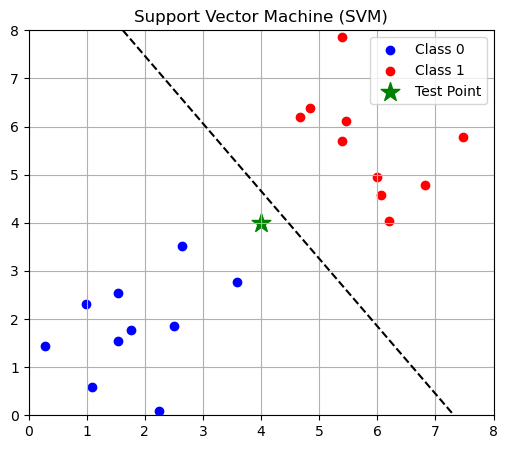

In [29]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Generate synthetic data for two classes
np.random.seed(42)
X1 = np.random.randn(10, 2) + [2, 2]  # Class 1
X2 = np.random.randn(10, 2) + [6, 6]  # Class 2

X = np.vstack((X1, X2))
y = np.hstack((np.zeros(10), np.ones(10)))

test_point = np.array([[4, 4]])

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(X, y)

xx, yy = np.meshgrid(np.linspace(0, 8, 100), np.linspace(0, 8, 100))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6, 5))

plt.contourf(xx, yy, Z > 0, alpha=0.2, colors=['white', 'white'])  
plt.contour(xx, yy, Z, levels=[0], colors='black', linestyles='dashed')  

plt.scatter(X1[:, 0], X1[:, 1], color='blue', label='Class 0')
plt.scatter(X2[:, 0], X2[:, 1], color='red', label='Class 1')
plt.scatter(test_point[:, 0], test_point[:, 1], color='green', marker='*', s=200, label='Test Point')

plt.gca().set_facecolor('white')
plt.title("Support Vector Machine (SVM)")
plt.legend()
plt.grid()
plt.show()
